<a href="https://colab.research.google.com/github/Guilherme-Nicolasi/resnet-lbp-alzheimer/blob/main/resnet-lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from skimage import feature
from google.colab.patches import cv2_imshow
from numpy.core.memmap import uint8

import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip '/content/alzheimers-dataset-4-class-of-images.zip'

unzip:  cannot find or open /content/alzheimers-dataset-4-class-of-images.zip, /content/alzheimers-dataset-4-class-of-images.zip.zip or /content/alzheimers-dataset-4-class-of-images.zip.ZIP.


#Funções Básicas

In [ ]:
def NormalImages(direction, label):
  list_dir = os.listdir(direction)
  new_list = []

  for i in list_dir:
    img= plt.imread(os.path.join(direction, i))
    new_list.append((img, label))

  return new_list

def Visualize(images):
    plt.figure(figsize=(14,8))
    for i in range(1,7):
        plt.subplot(2,3,i)
        img= images[i]
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

def Area(img):
  numPixels = 0

  for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      if img[y][x] == 255:
        numPixels +=1

  return numPixels

#Adquirindo as Imagens

In [ ]:
drive = True

In [ ]:
if drive == True:
  demented = NormalImages('../content/drive/MyDrive/Colab Notebooks/Processamento Imagens/MRI/Alzheimer_s Dataset/Demented', 1)
  nonDemented = NormalImages('../content/drive/MyDrive/Colab Notebooks/Processamento Imagens/MRI/Alzheimer_s Dataset/NonDemented', 0)
else:
  demented = NormalImages('../content/Alzheimer_s Dataset/test/MildDemented', 1)
  demented = np.concatenate([demented , NormalImages('../content/Alzheimer_s Dataset/train/MildDemented', 1)])
  demented = np.concatenate([demented , NormalImages('../content/Alzheimer_s Dataset/test/VeryMildDemented', 1)])
  demented = np.concatenate([demented , NormalImages('../content/Alzheimer_s Dataset/train/VeryMildDemented', 1)])
  demented = np.concatenate([demented , NormalImages('../content/Alzheimer_s Dataset/test/VeryMildDemented', 1)])
  demented = np.concatenate([demented , NormalImages('../content/Alzheimer_s Dataset/train/ModerateDemented', 1)])
  nonDemented = NormalImages('../content/Alzheimer_s Dataset/test/NonDemented', 0)
  nonDemented = np.concatenate([nonDemented, NormalImages('../content/Alzheimer_s Dataset/train/NonDemented', 0)])

In [ ]:
final_list = np.concatenate([demented, nonDemented])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# 1- Equalização

In [ ]:
def Equalize(images):
  new_list = []

  for img in images:
    new_image = cv2.equalizeHist(img[0])
    new_list.append([new_image, img[1]])

  return new_list

In [ ]:
#demented_Equalized = Equalize(demented)
#nonDemented_Equalized = Equalize(nonDemented)

final_list_Equalized = Equalize(final_list)

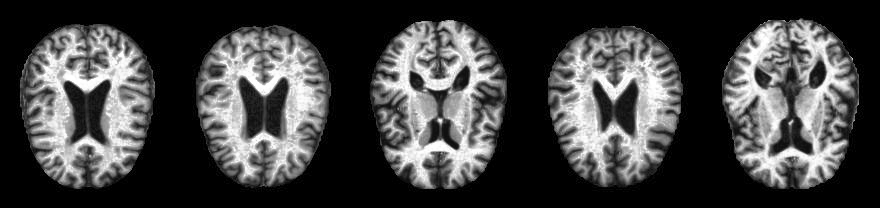

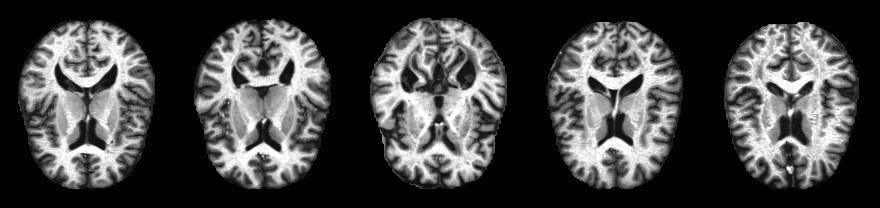

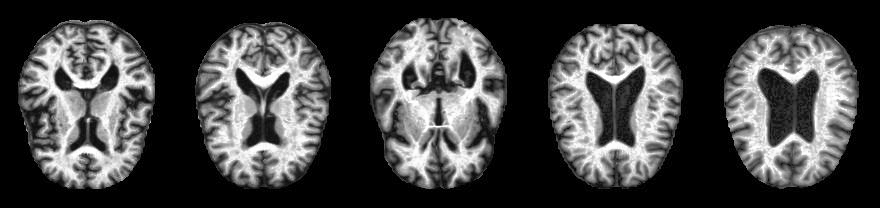

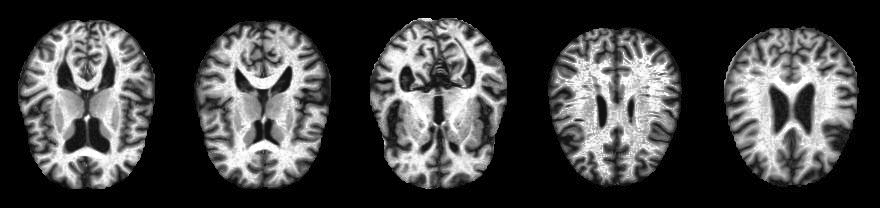

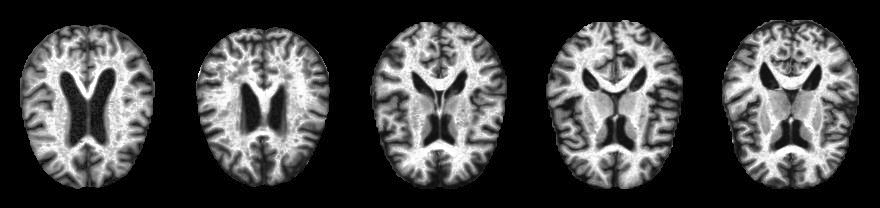

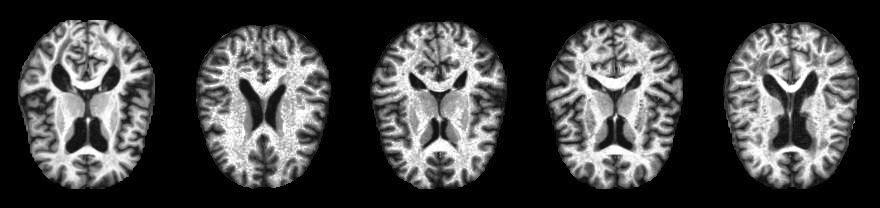

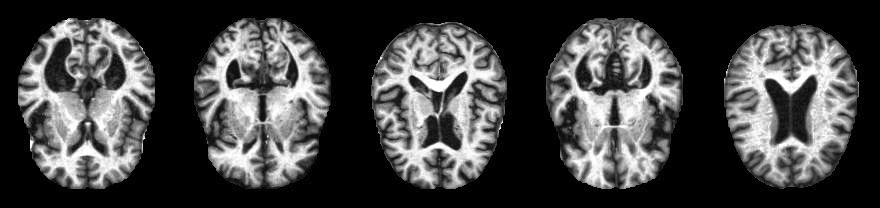

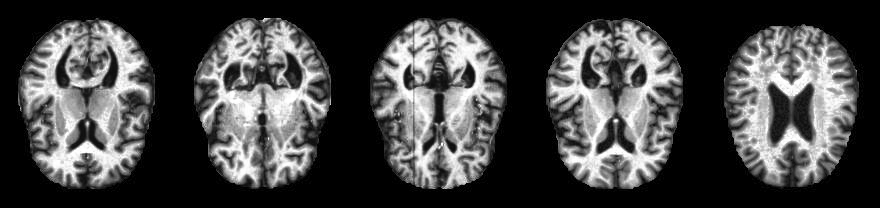

In [ ]:
random_id = rd.sample(range(len(final_list_Equalized)), 40)

new_set = [final_list_Equalized[i] for i in random_id]
line = []
for h in new_set:
  line.append(h[0])
  if len(line) == 5:
    cv2_imshow(np.concatenate([line[0], line[1], line[2], line[3], line[4]], axis=1))
    print('')
    line = []

#2- Pseudo-Cor

In [ ]:
def PseudoColor(_list):
  newList = []
  for i in _list:
    newList.append([cv2.applyColorMap(i[0], cv2.COLORMAP_JET), i[1]])

  return newList

In [ ]:
pseudo = PseudoColor(final_list_Equalized)

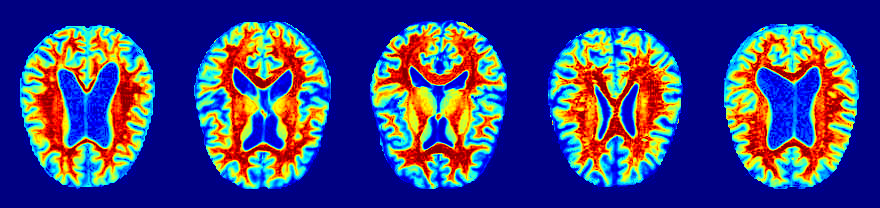

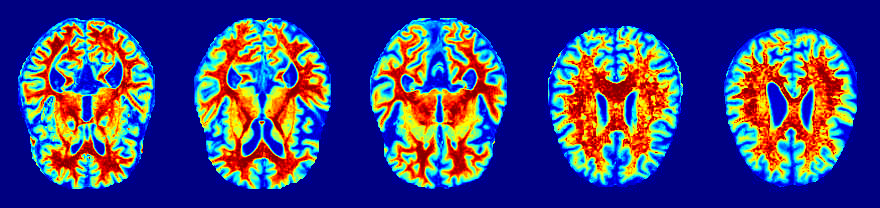

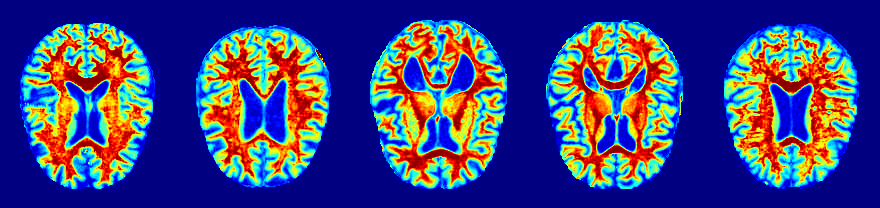

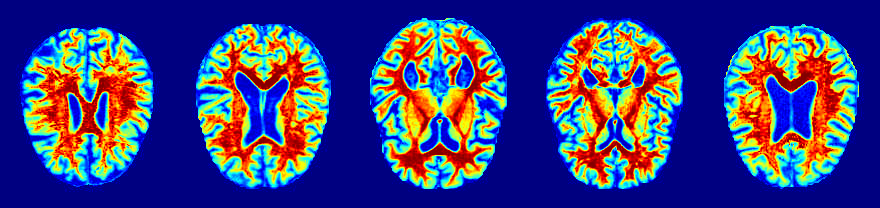

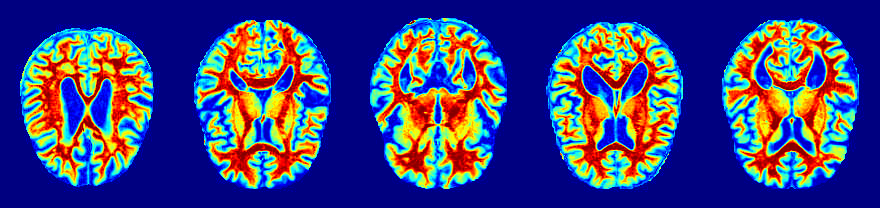

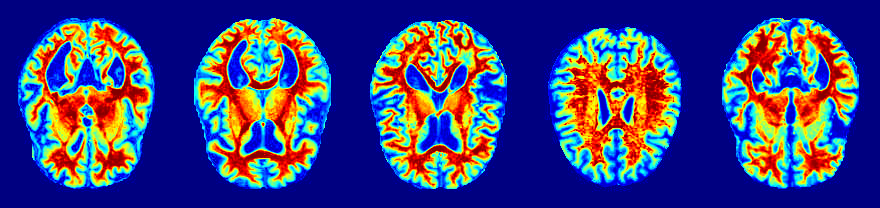

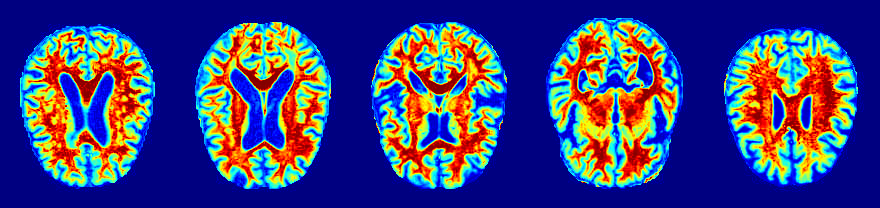

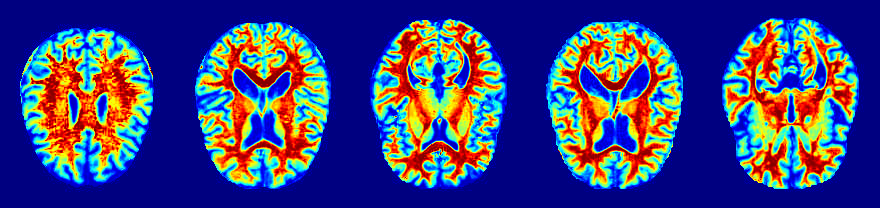

In [ ]:
random_id = rd.sample(range(len(pseudo)), 40)

new_set = [pseudo[i] for i in random_id]
line = []
for h in new_set:
  line.append(h[0])
  if len(line) == 5:
    cv2_imshow(np.concatenate([line[0], line[1], line[2], line[3], line[4]], axis=1))
    print('')
    line = []

#3- LBP

In [ ]:
def LBP_Function(image):
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #imgLBP = np.zeros_like(gray_image)
  vector = np.zeros(256)
  neighboor = 3

  for ih in range(0, image.shape[0] - neighboor):
    for iw in range(0, image.shape[1] - neighboor):
      img          = gray_image[ih:ih+neighboor, iw:iw+neighboor]
      center       = img[1,1]
      img01        = (img >= center)*1.0
      img01_vector = img01.T.flatten()

      img01_vector = np.delete(img01_vector,4)

      where_img01_vector = np.where(img01_vector)[0]
      if len(where_img01_vector) >= 1:
        num = np.sum(2**where_img01_vector)
      else:
        num = 0
      vector[num] += 1
      #imgLBP[ih+1,iw+1] = num
  return vector


def LBP(_list):
  newList = []
  for i in _list:
    newList.append([LBP_Function(i[0]), i[1]])

  return newList

In [ ]:
LBP_features = LBP(pseudo)

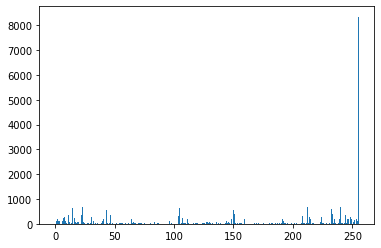

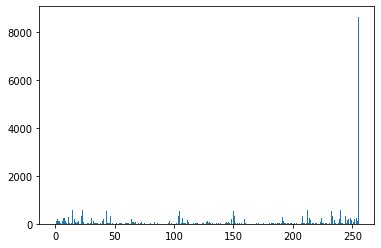

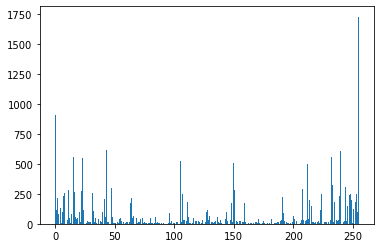

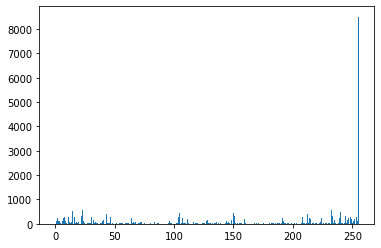

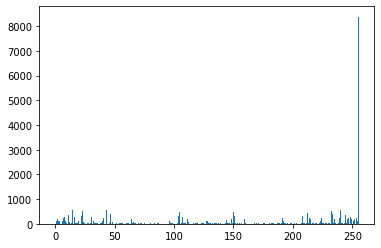

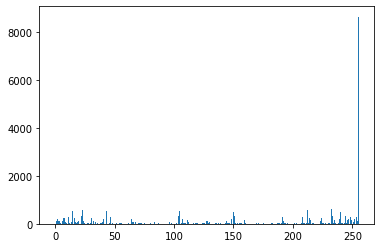

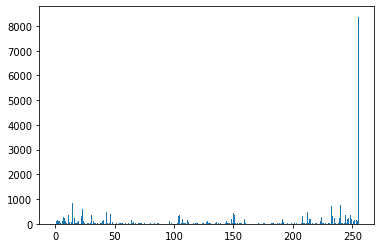

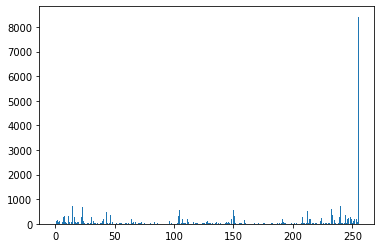

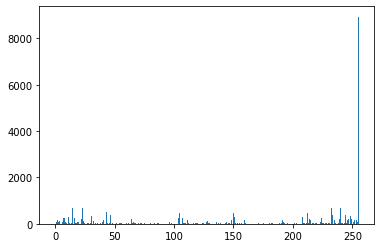

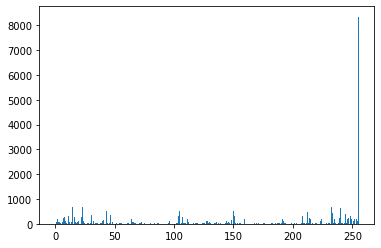

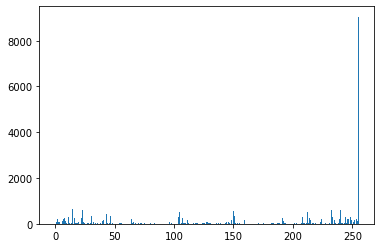

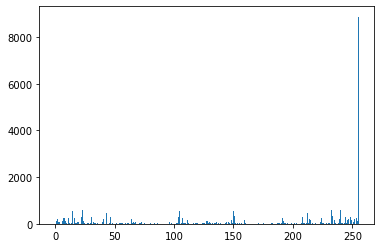

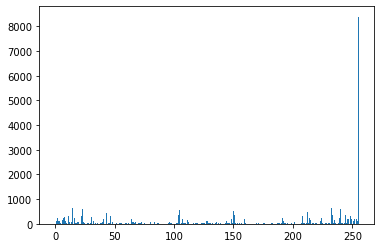

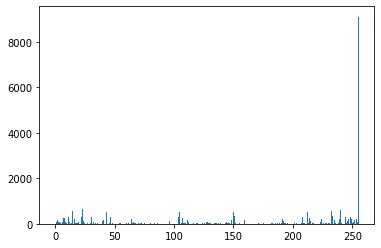

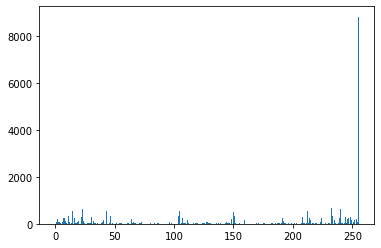

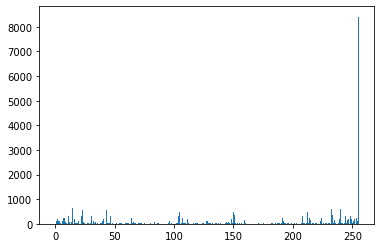

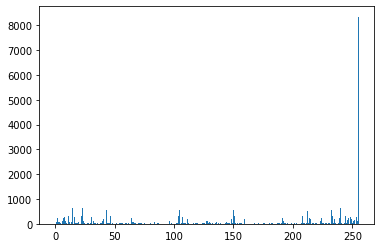

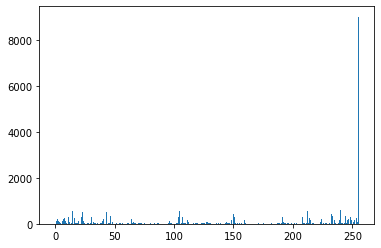

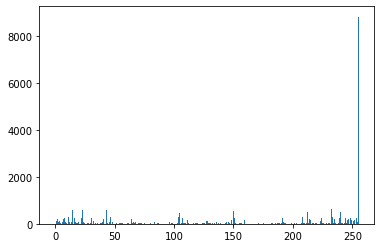

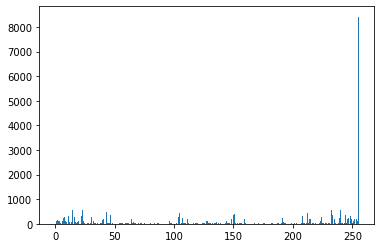

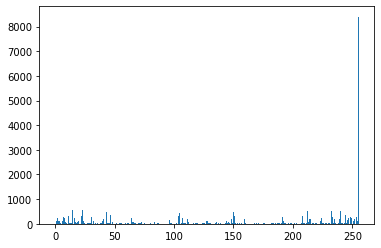

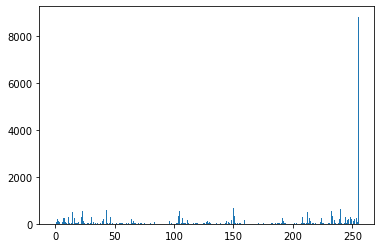

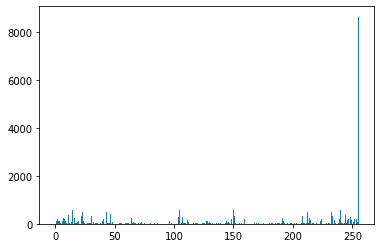

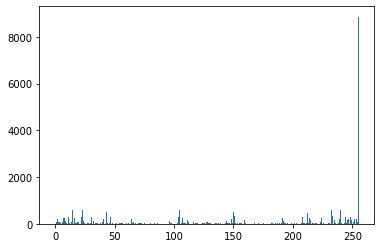

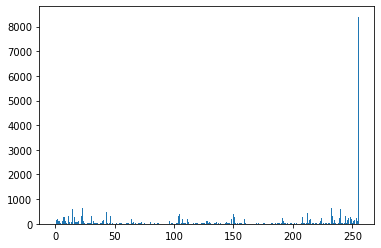

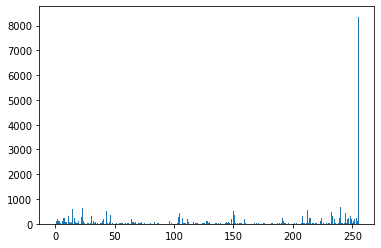

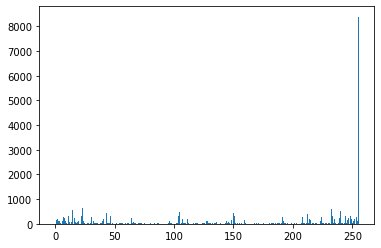

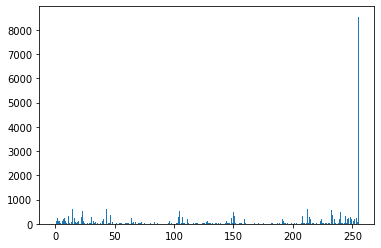

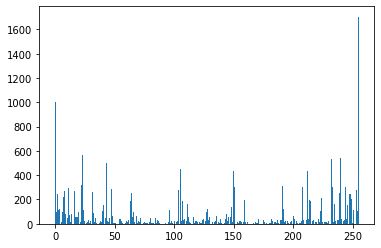

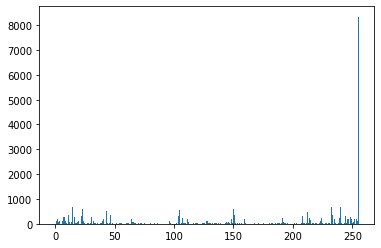

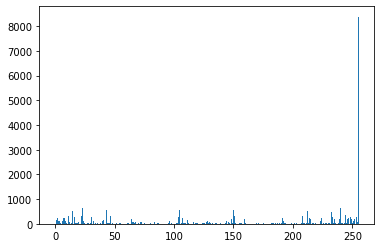

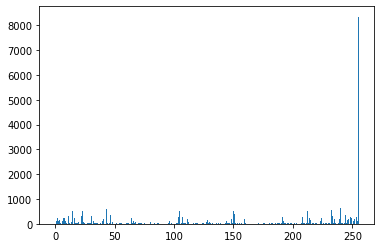

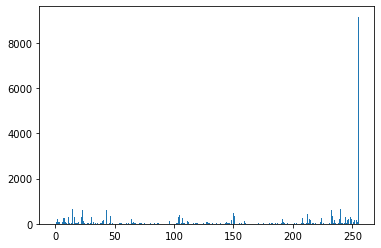

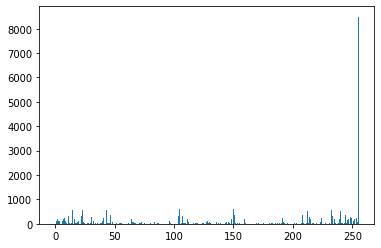

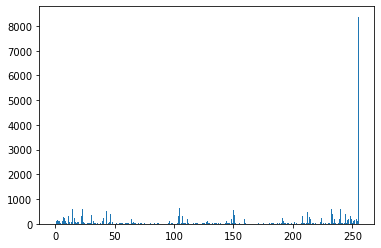

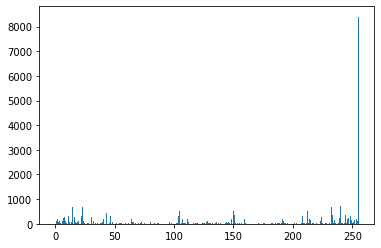

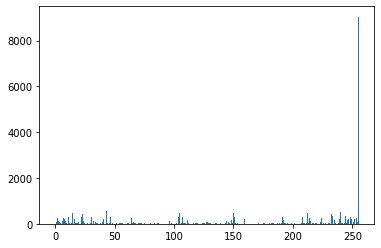

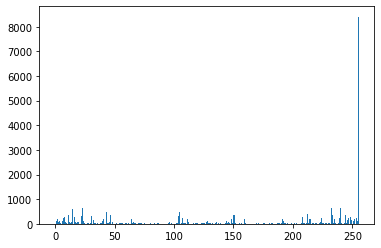

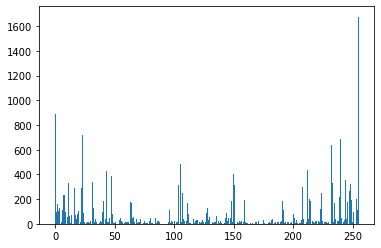

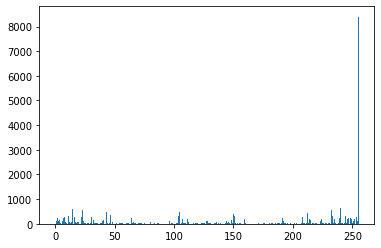

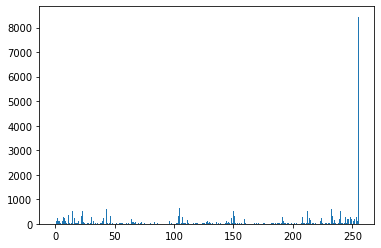

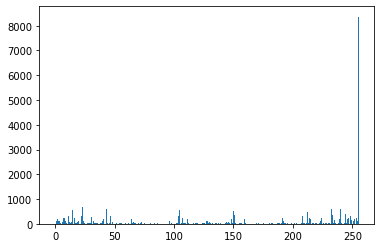

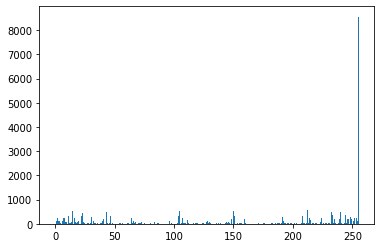

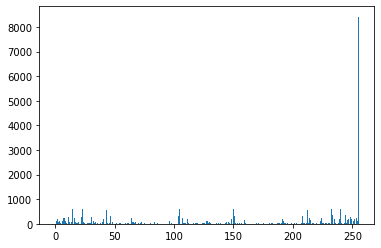

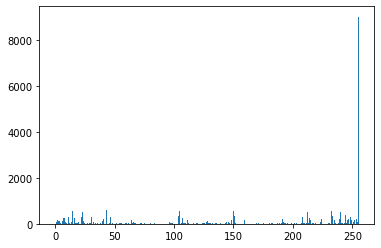

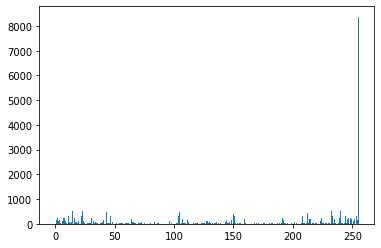

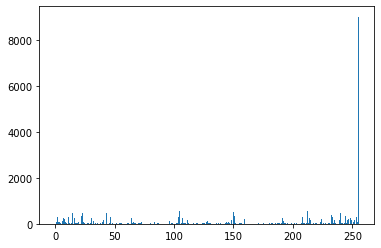

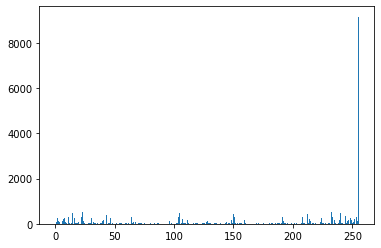

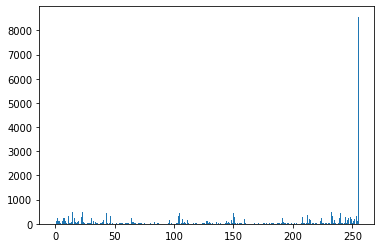

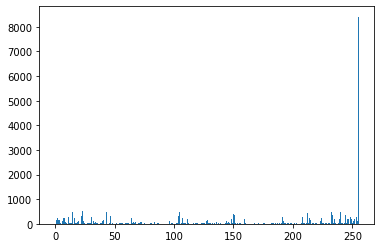

In [ ]:
random_id = rd.sample(range(len(LBP_features)), 50)

new_set = [LBP_features[i] for i in random_id]
line = []
for h in new_set:
  h[0][255] = h[0][255] / 2
  eixo_x = np.arange(256)
  plt.bar(eixo_x, h[0])
  plt.show()

O gráfico mostra a feature adquirida, no entanto, é possível ver uma discrepância entre o 255 e o resto pois o fundo da imagem foi somado a feature

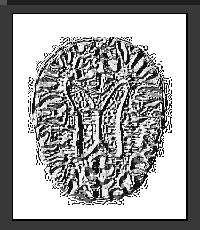
Um exemplo de resultado do LBP

#4- Cross-validation

In [ ]:
train_sets = []
test_sets = []
size_dataset = math.floor(len(final_list) * 0.9)
for i in range(5):
    random_id = rd.sample(range(len(final_list)), size_dataset)
    new_set = [final_list[i] for i in random_id]
    folds = list(KFold(n_splits=2, shuffle=True).split(new_set))
    for j, (train_index, test_index) in enumerate(folds):
        train = [new_set[i] for i in train_index]
        test = [new_set[i] for i in test_index]

        train_sets.append(train)
        test_sets.append(test)

#5- DataSet Wrapper

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_set, transform=None):
        self.data_set = data_set
        self.transform = transform

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        image, label = self.data_set[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

#6- ResNet-18

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transform = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((176, 208)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std),
])

epochs = 5
batch_size = 64
for i in range(len(train_sets)):
    model = models.resnet18(pretrained=True)
    model = model.to(device)
    if device == 'cuda':
      model = torch.nn.DataParallel(model)
      cudnn.benchmark = True

    train_dataset = Dataset(train_sets[i], transform=transform)
    test_dataset = Dataset(test_sets[i], transform=transform)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
    )

    learning_rate, momentum = 0.001, 0.9
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            with torch.set_grad_enabled(True):
              loss.backward()
              optimizer.step()
            print("ID {} Epoch {}: loss = {}".format(i, epoch, loss.item()))

    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    model.eval()
    with torch.no_grad():
      for images, labels in train_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          train_features.append(outputs)
          train_labels.append(labels)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_features.append(outputs)
            test_labels.append(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy: {} %'.format(100 * correct / total))
    train_features = torch.cat(train_features, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    test_features = torch.cat(test_features, dim=0)
    test_labels = torch.cat(test_labels, dim=0)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ID 0 Epoch 0: loss = 9.075531005859375
ID 0 Epoch 0: loss = 9.014257431030273
ID 0 Epoch 0: loss = 8.301921844482422
ID 0 Epoch 0: loss = 7.583704471588135
ID 0 Epoch 0: loss = 6.689127445220947
ID 0 Epoch 0: loss = 5.4219183921813965
ID 0 Epoch 0: loss = 4.370571613311768
ID 0 Epoch 0: loss = 3.326716899871826
ID 0 Epoch 0: loss = 1.8873848915100098
ID 0 Epoch 0: loss = 1.4313246011734009
ID 0 Epoch 0: loss = 0.9057669639587402
ID 0 Epoch 0: loss = 1.0190426111221313
ID 0 Epoch 0: loss = 0.9131773710250854
ID 0 Epoch 0: loss = 0.8606924414634705
ID 0 Epoch 0: loss = 0.53987056016922
ID 0 Epoch 0: loss = 0.5132851600646973
ID 0 Epoch 0: loss = 0.5066834092140198
ID 0 Epoch 0: loss = 0.7849733233451843
ID 0 Epoch 0: loss = 0.9179090857505798
ID 0 Epoch 0: loss = 0.4751826822757721
ID 0 Epoch 0: loss = 0.5539399981498718
ID 0 Epoch 0: loss = 0.563042402267456
ID 0 Epoch 0: loss = 0.42537814378738403
ID 0 Epoch 0: loss = 0.6661369204521179
ID 0 Epoch 0: loss = 0.45849502086639404
ID 0 Epo

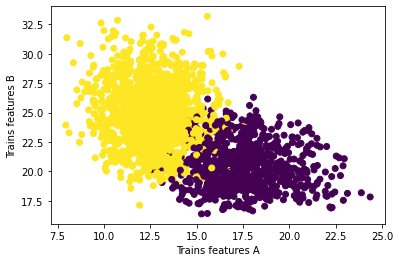

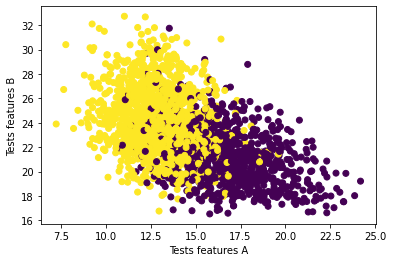

In [ ]:
train_features_np = train_features.cpu().numpy()
train_labels_np = train_labels.cpu().numpy()

plt.scatter(train_features_np[:,0], train_features_np[:,1], c=train_labels_np)
plt.xlabel('Trains features A')
plt.ylabel('Trains features B')
plt.show()

test_features_np = test_features.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()

plt.scatter(test_features_np[:,0], test_features_np[:,1], c=test_labels_np)
plt.xlabel('Tests features A')
plt.ylabel('Tests features B')
plt.show()

#7- SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
labels_CNN = np.concatenate([train_labels.cpu().numpy(), test_labels.cpu().numpy()])
X_CNN = np.concatenate([train_features.cpu().numpy(), test_features.cpu().numpy()])

X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X_CNN, labels_CNN, test_size=0.2, random_state=42)

clf_CNN = svm.SVC(kernel='linear')
clf_CNN.fit(X_train_CNN, y_train_CNN)
y_pred_CNN = clf_CNN.predict(X_test_CNN)

print("Accuracy: {:.2f}%".format(100 * (accuracy_score(y_test_CNN, y_pred_CNN))))

Accuracy: 91.98%


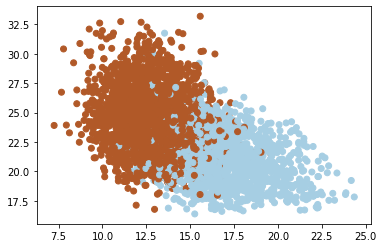

In [ ]:
x_min, x_max = X_train_CNN[:, 0].min() - 1, X_train_CNN[:, 0].max() + 1
y_min, y_max = X_train_CNN[:, 1].min() - 1, X_train_CNN[:, 1].max() + 1

h = ((x_max / x_min) / 100)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.vstack([xx.ravel(), yy.ravel()]).T

plt.scatter(X_train_CNN[:, 0], X_train_CNN[:, 1], c=y_train_CNN, cmap=plt.cm.Paired)

plt.xlim(xx.min(), xx.max())
plt.show()

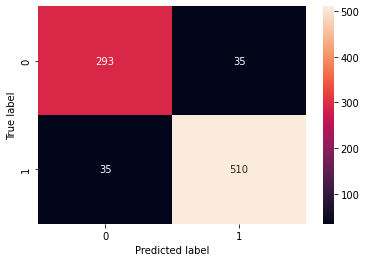

In [ ]:
conf_matrix = confusion_matrix(y_test_CNN, y_pred_CNN)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
x = []
label = []
for i in LBP_features:
  x.append(i[0])
  label.append(i[1])

X_LBP = x
labels_LBP = label

X_train_LBP, X_test_LBP, y_train_LBP, y_test_LBP = train_test_split(X_LBP, labels_LBP, test_size=0.2, random_state=42)

clf_LBP = SVC(kernel='linear')
clf_LBP.fit(X_train_LBP, y_train_LBP)

y_pred_LBP = clf_LBP.predict(X_test_LBP)

acc_LBP = accuracy_score(y_test_LBP, y_pred_LBP)
print("Accuracy LBP: {:.2f}%".format(acc_LBP*100))

Accuracy LBP: 66.59%


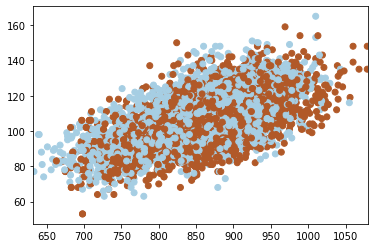

In [ ]:
x_min_LBP, x_max_LBP = np.array(X_train_LBP)[:, 0].min() - 1, np.array(X_train_LBP)[:, 0].max() + 1
y_min_LBP, y_max_LBP = np.array(X_train_LBP)[:, 1].min() - 1, np.array(X_train_LBP)[:, 1].max() + 1
h_LBP = ((x_max_LBP / x_min_LBP) / 100)
xx_LBP, yy_LBP = np.meshgrid(np.arange(x_min_LBP, x_max_LBP, h_LBP), np.arange(y_min_LBP, y_max_LBP, h_LBP))

plt.scatter(np.array(X_train_LBP)[:, 0], np.array(X_train_LBP)[:, 1], c=y_train_LBP, cmap=plt.cm.Paired)
plt.xlim(xx_LBP.min(), xx_LBP.max())
plt.show()